<a href="https://colab.research.google.com/github/neurologic/NeurophysiologyModules/blob/main/Kinematics_WithPCA_WBDSdataset_WithOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
> Each of the section headers in this table of contents is linked to the sections of the notebooks to help you navigate. 

1. [Introduction](#scrollTo=5be65f0d-d29b-4756-ab52-b080ba4a24d5)
2. [Preparatory Steps](#scrollTo=770856d7-2f01-469c-b77e-e0026b48763b)
3. Raw Data 
- Dataset Selection and Loading
 - [select a dataset](#scrollTo=edbebb54-81d1-4cc7-a4ab-70ecf17c11e5)
 - [load the selected dataset](#scrollTo=Hw0TwgunODC-)
- [Menu](#scrollTo=RFTAKrAzZ2jN) of analyses for the raw dataset (Steps 4-6 below)
 - [4. Explore raw kinematics data](#scrollTo=31d41f94-24df-4420-ac7d-639a2b48b37e)
 - [5. Explore ground reaction force data](#scrollTo=80923d9b-7946-40ec-b795-838718d7a116)
 - [6. Identify individual gait cycle trials](#scrollTo=iR6gql9Ba4NT)
7. Processed Data: [Analyze time-normalized and processed data](#scrollTo=51cdb5b3-5657-43c3-8ccf-c8147e5f7efb)
8. [Low-dimensional representation of walking](#scrollTo=hXStrNF_ANpn)

# 1. Introduction
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

Kinematics is the study and quantification of how objects move. In this notebook you will explore a dataset from [Fukuchi et al (2018)](https://peerj.com/articles/4640/) in which markers placed at specific locations along the body were tracked during walking (either overland or on a treadmill). Note that the nomenclature for the marker points in this dataset vary slightly from [the marker placement resource](https://www.sciencedirect.com/science/article/pii/S0966636207000124?via%3Dihub)  referenced in Fukuchi et al (2018). Force plates were used to quantify ground contact forces during walking ("kinetics"). 

<img src='https://drive.google.com/uc?export=view&id=1zuawHOnk-Y_rs4wkqpXP_PnNPdHYTZZ4' width=300px>


# 2) Some necessary preparatory steps.
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

In [1]:
#@markdown <b>TASK: </b> RUN this cell to set up the notebook (import packages, etc)
# In Python, anything with a "#" in front of it is code annotation,
# and is not read by the computer.
# You can run a cell (this box) by pressing ctrl-enter or shift-enter.
# You can also run a cell by clicking the play button in the menu bar 
# at the top of the page (single right arrow, not double).
# Click in this cell and then press shift and enter simultaneously.
# This print function below allows us to generate a message.
print('Nice work!')

# No need to edit anything in this code cell
#################################

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.signal import find_peaks
from copy import deepcopy
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import csv
from scipy.signal import hilbert,medfilt,resample
from scipy.io import wavfile
from sklearn.decomposition import PCA
import scipy
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()


# datafolder = "/content/drive/Shareddrives/BIOL358/Data/WBDSascii"
datafolder = "/content/drive/MyDrive/Classroom/BIOL358: Motor Systems/Data/WBDSascii"
# datafolder = '/Users/kperks/OneDrive - wesleyan.edu/Teaching/MotorSystems_SP22/Data/WBDSascii/'

fs_grf = 300
fs_mkr = 150

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Nice work!
Task completed at 2022-01-28 09:07:27.648852-05:00


In [2]:
#@markdown <b>TASK: </b> RUN this cell to mount your Google Drive, where you will access the raw data from.
#@markdown > Follow all instructions as prompted by pop-ups.
from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Mounted at /content/drive
Task completed at 2022-01-28 09:07:47.885478-05:00


# 3) Select which raw data (who, where, how fast?).  
[Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs)

Choose a person, environment, and speed (note different selection options based on the environment chosen). 

> <b> TASK (*one time per active notebook session*): </b> Run the code cell below to activate the dropdown menus for selection.
> > NOTE: you should only need to run the code cell below once per active colab session to activate the dropdown menus. If you can change your selections, it is activated. You can change your selections at any time and load your selection using the [Load Dataset](#scrollTo=Hw0TwgunODC-) code cell.

In [3]:
#@markdown Activate Dropdown Menus if needed.
 
w_subj = widgets.Select(
    options=['select person (01-42)'] + [format(x,'02d') for x in range(1,43,1)],
    value='select person (01-42)',
    # rows=10,
    disabled=False
)
w_env = widgets.Select(
    options=['select environment','Overland','Treadmill'],
    value='select environment',
    rows=3,disabled=False
)
w_Ospeed = widgets.Select(
    options=['select speed for overland','Comfortable','Fast','Slow'],
    value='select speed for overland',
    rows=4,disabled=False
)
w_Tspeed = widgets.Select(
    options=['select speed for treadmill (01-08)'] + [format(x,'02d') for x in range(1,9,1)],
    value='select speed for treadmill (01-08)',
    rows=5,disabled=False
)
display(w_subj,w_env,w_Ospeed,w_Tspeed)
print('Dropdowns generated at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Select(options=('select person (01-42)', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12…

Select(options=('select environment', 'Overland', 'Treadmill'), rows=3, value='select environment')

Select(options=('select speed for overland', 'Comfortable', 'Fast', 'Slow'), rows=4, value='select speed for o…

Select(options=('select speed for treadmill (01-08)', '01', '02', '03', '04', '05', '06', '07', '08'), value='…

Dropdowns generated at 2022-01-28 09:07:48.671189-05:00


Once you have made your selection, then load the dataset.

<b> TASK: </b> Run the code cell below to load the dataset [you selected above](#scrollTo=edbebb54-81d1-4cc7-a4ab-70ecf17c11e5)

In [6]:
#@markdown ## **Load Dataset**
#@markdown >Note: If you change your dataset selections above, re-run this cell.
#@markdown You only need to load each dataset once, 
#@markdown You can make new Kinematics and Kinetics selections from the menus
#@markdown below without re-running this cell. 

if w_env.value=='Overland':
    speed = w_Ospeed.value[0]
    trial = '01'
if w_env.value=='Treadmill':
    speed = w_Tspeed.value
    trial = ''

filename = 'WBDS' + str(w_subj.value) + 'walk' + w_env.value[0] + trial + speed 

filepath = Path(datafolder) / (filename + 'mkr.txt')
if filepath.exists():
    dataframe = pd.read_csv(filepath, sep='\t')
    print('Kinematic Data loaded at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if filepath.exists()==False:
    print('Data selection does not exist. Check selections and correct errors.')
    print('Task not yet completed, but cell ran at ' + str(datetime.now(timezone(-timedelta(hours=5)))))    

filepath_grf = Path(datafolder) / (filename + 'grf.txt')
if filepath_grf.exists():
    grf_trial = pd.read_csv(filepath_grf,sep='\t')
    grf_trial['Time']/=fs_grf
    print('Kinetic Data loaded at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if filepath_grf.exists()==False:
    print('Data selection does not exist. Check selections and correct errors.')
    print('Task not yet completed, but cell ran at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

w_markers = widgets.SelectMultiple(
    options=list(dataframe.columns)[1:],
    rows=15)

w_fp = widgets.SelectMultiple(
    options=list(grf_trial.columns)[1:],
    rows=10)
print('')
print('')
print('Select which kinematics variables you want to plot from the following list:')
display(w_markers)
print('')
print('')
print('Select which kinetic variables you want to plot from the following list:')
display(w_fp)
print('Dropdown menus created at ' + str(datetime.now(timezone(-timedelta(hours=5)))))






Kinematic Data loaded at 2022-01-28 09:10:43.122037-05:00
Kinetic Data loaded at 2022-01-28 09:10:43.434785-05:00


Select which kinematics variables you want to plot from the following list:


SelectMultiple(options=('R.ASISX', 'R.ASISY', 'R.ASISZ', 'L.ASISX', 'L.ASISY', 'L.ASISZ', 'R.PSISX', 'R.PSISY'…



Select which kinetic variables you want to plot from the following list:


SelectMultiple(options=('Fx1', 'Fy1', 'Fz1', 'COPx1', 'COPy1', 'COPz1', 'Ty1', 'Fx2', 'Fy2', 'Fz2', 'COPx2', '…

Dropdown menus created at 2022-01-28 09:10:43.474637-05:00


### Raw data analysis menu:
> With the selections you have made above, you can:
- [4) Explore the raw kinematics data](#scrollTo=31d41f94-24df-4420-ac7d-639a2b48b37e)
- [5) Explore the ground reaction force data from treadmill environments](#scrollTo=80923d9b-7946-40ec-b795-838718d7a116)
- [6) Identify individual gait cycle trials](#scrollTo=iR6gql9Ba4NT) and 
   - [create plots of gait cycle trials](#scrollTo=4N8i5DBwchGM) for: [kinetic](#scrollTo=3EApNSSgr3vu) and [kinematic](#scrollTo=FHFS8FMxd1jv) variables.  

[Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs)

# 4) Explore the raw kinematics data
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

**TASK:** Run the cell below to plot the [selected kinematics variables](#scrollTo=Hw0TwgunODC-) for your [selected dataset](#scrollTo=edbebb54-81d1-4cc7-a4ab-70ecf17c11e5). You can select different kinematics variables and re-make the plot as many times as you want. 

In [8]:
#@markdown **Plot Selected Kinematic Variables**
fig = go.Figure()
if len(w_markers.value)>0:
    for marker in list(w_markers.value):
        fig.add_trace(go.Scatter(x = dataframe['Time'], y = dataframe[marker],name=marker))
    print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if len(w_markers.value)==0:
    print('Need to select markers to plot')
    print('Task not completed yet, but cell run at ' + str(datetime.now(timezone(-timedelta(hours=5)))))
    
fig.update_layout(xaxis_title="time(seconds)", yaxis_title='position (centimeters)',width=800, height=500)

Task completed at 2022-01-28 09:11:34.503304-05:00


# 5) Explore ground reaction force data 
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

**TASK:** Go back to [modify your dataset selections (step 3)](#scrollTo=edbebb54-81d1-4cc7-a4ab-70ecf17c11e5) so that you have data from a Treadmill environment. Don't forget to also [load the dataset (step3)](#scrollTo=Hw0TwgunODC-). Select a subset of ground force measurements to examine. Run the cell below to plot your selection. 

In [10]:
#@markdown **Plot the ground reaction force measurements you selected.**

fig = go.Figure()
if len(w_fp.value)>0:
    for fp in list(w_fp.value):
        fig.add_trace(go.Scatter(x = grf_trial['Time'], y = grf_trial[fp],name=fp))
    print('Plot created at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if len(w_fp.value)==0:
    print('Need to select markers to plot')
    print('Task not completed, but cell run at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

fig.update_layout(xaxis_title="time(seconds)", yaxis_title='force',width=800, height=500)



Plot created at 2022-01-28 09:13:25.159025-05:00


#6) Identify individual gait cycle trials
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

<b>TASK: </b> Based on the ground force measurements you [plotted above](#scrollTo=497d8d55-d565-4e1a-a54e-c7da8ba2d772), determine 3 trial start times to start. Each trial is a single gait cycle. 

In the code cell below, there is a form with spots to create a list of trial start times and assign a variable for the approximate gait cycle period. Single click just above the line (or highlight the text) to edit the form entries. After filling in the necessary information, run the code cell to store the information into temporary memory. 

In [11]:
#@markdown <b>TASK: </b> Type a list of trial times below. 
#@markdown >The formatting of the list must be trial start times (in seconds)
#@markdown separated by commas. The whole list must be surrounded by hard brackets. 
#@markdown For example: ```[1.24,5.67,8.98]```
trials = [11.9,12.9,13.8,14.7,16.6] #@param {type:"raw"}

#@markdown <b>TASK: </b> Type the gait cycle period below (in seconds). 
period =  1.5#@param {type:"number"}

#@markdown <b>TASK: </b> After you have created a list of start times 
#@markdown and specified a period, run this cell to store the values in memory for the next task. 

offset = 0.5
persamps = int(period*fs_grf)+int(offset*fs_grf)
trial_inds = [int((t-offset)*fs_grf) for t in trials]
xtime = np.linspace(-offset,period,persamps)

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))



Tasks completed at 2022-01-28 09:15:10.173864-05:00


### Create plots of trial data.
([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

**TASK:** Go back to [select kinematic and kinetic variables](#scrollTo=Hw0TwgunODC-) from the dataset to examine on the trials [you specified above](#scrollTo=1814abac-ca52-4ddb-8490-b131456a3eba). Run the cells below to plot your selections. 

> You can change the values listed for "trials" and "period" and re-make the plots below at any time.
> NOTE: if you change the trial times or period, you need to [re-run that cell](#scrollTo=1814abac-ca52-4ddb-8490-b131456a3eba) before re-running the plotting code cells below. 


In [12]:
#@markdown Plot the kinetic measurements on each trial specified.

offset = 0.5
persamps = int(period*fs_grf)+int(offset*fs_grf)
trial_inds = [int((t-offset)*fs_grf) for t in trials]
xtime = np.linspace(-offset,period,persamps)

fig = go.Figure()

if len(w_fp.value)>0:
    for fp in list(w_fp.value):
      for t in trial_inds:
        fig.add_trace(go.Scatter(x = xtime, y = grf_trial[fp][t:t+persamps],name=fp+' at trial ' +str(round(t/fs_grf,2)+offset)))
    print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if len(w_fp.value)==0:
    print('Need to select markers to plot')
    print('Task not completed, but cell run at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

fig.update_layout(xaxis_title="time(seconds)", yaxis_title='force',width=800, height=500)



Task completed at 2022-01-28 09:15:15.198141-05:00


([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

In [54]:

#@markdown Plot the kinematics measurements on each trial specified.

offset = 0.5
persamps = int(period*fs_mkr)+int(offset*fs_mkr)
trial_inds = [int((t-offset)*fs_mkr) for t in trials]
xtime = np.linspace(-offset,period,persamps)

fig = go.Figure()

if len(w_markers.value)>0:
    for marker in list(w_markers.value):
      for t in trial_inds:
        fig.add_trace(go.Scatter(x = xtime, y = dataframe[marker][t:t+persamps],name=str(marker)+' at trial ' +str(round(t/fs_mkr,2))))
    print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

if len(w_markers.value)==0:
    print('Need to select markers to plot')
    print('Task not completed, but cell run at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

fig.update_layout(xaxis_title="time(seconds)", yaxis_title='force',width=800, height=500)


Task completed at 2022-01-28 09:34:05.272589-05:00


([Return to Raw Data Analysis Menu](#scrollTo=RFTAKrAzZ2jN))

# 7) Analyze time-normalized processed data
([Return to Table of Contents](#scrollTo=Y1JpSgWhMmRs))

Ok. Now that you have a sense of the data, let's look at time-normalized processed data. 



### Select which data you want to examine (who, where, how fast?).  
From the menus in the cell below, choose a person, environment, and speed (note different selection options based on the environment chosen). 

In this step, the data that you will explore is trial-averaged measurements (the average across trials for each. The data is "time-normalized" so that the kinematics and kinetics are a function of the gait cycle (from start to stop - 0 to 100% of the gait cycle) instead of time. 

> <b> TASK (*one time per active notebook session*): </b> Run the code cell below to activate the dropdown menus for selection.
> > NOTE: you should only need to run the code cell below once per active colab session to activate the dropdown menus. If you can change your selections, it is activated. You can change your selections at any time and load your selection using the [Load Dataset](#scrollTo=Hw0TwgunODC-) code cell.

In [14]:
#@markdown Activate Dropdown Menus if needed.
 
w_subj = widgets.Select(
    options=['select person (01-42)'] + [format(x,'02d') for x in range(1,43,1)],
    value='select person (01-42)',
    # rows=10,
    disabled=False
)
w_env = widgets.Select(
    options=['select environment','Overland','Treadmill'],
    value='select environment',
    rows=3,disabled=False
)
w_Ospeed = widgets.Select(
    options=['select speed for overland','Comfortable','Fast','Slow'],
    value='select speed for overland',
    rows=4,disabled=False
)
w_Tspeed = widgets.Select(
    options=['select speed for treadmill (01-08)'] + [format(x,'02d') for x in range(1,9,1)],
    value='select speed for treadmill (01-08)',
    rows=5,disabled=False
)
display(w_subj,w_env,w_Ospeed,w_Tspeed)
print('Dropdowns generated at ' + str(datetime.now(timezone(-timedelta(hours=5)))))



Select(options=('select person (01-42)', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12…

Select(options=('select environment', 'Overland', 'Treadmill'), rows=3, value='select environment')

Select(options=('select speed for overland', 'Comfortable', 'Fast', 'Slow'), rows=4, value='select speed for o…

Select(options=('select speed for treadmill (01-08)', '01', '02', '03', '04', '05', '06', '07', '08'), value='…

Dropdowns generated at 2022-01-28 09:16:03.961118-05:00


<b> TASK: </b> Once you have made your selection, then load the dataset. Run the code cell below to load the dataset [you selected above](#scrollTo=WFZLoPamhej1)

In [15]:


#@markdown ## **Load Dataset**
#@markdown >Note: If you change your dataset selections above, re-run this cell.
#@markdown You only need to load each dataset once, 
#@markdown You can make new Kinematics and Kinetics selections from the menus
#@markdown below without re-running this cell. 

if w_env.value=='Overland':
    speed = w_Ospeed.value[0]

if w_env.value=='Treadmill':
    speed = w_Tspeed.value

filename_norm = 'WBDS' + str(w_subj.value) + 'walk' + w_env.value[0] + speed 

filepath_norm = Path(datafolder) / (filename_norm + 'ang.txt')
ang_norm = pd.read_csv(filepath_norm,sep = '\t')
print('Processed kinematics data loaded.')
w_norm_ang = widgets.SelectMultiple(
    options=list(ang_norm.columns)[1:],
    rows=10)

filepath_norm = Path(datafolder) / (filename_norm + 'knt.txt')
grf_norm = pd.read_csv(filepath_norm,sep = '\t')
print('Processed ground fource data loaded.')
w_norm_grf = widgets.SelectMultiple(
    options=list(grf_norm.columns)[1:],
    rows=10)
print('')
print('')
print('Select which processed kinematics variables to plot from the following list (ctrl + click to select multiple).')
display(w_norm_ang)
print('')
print('Select which processed ground force variables to plot from the following list (ctrl + click to select multiple).')
display(w_norm_grf)



Processed kinematics data loaded.
Processed ground fource data loaded.


Select which processed kinematics variables to plot from the following list (ctrl + click to select multiple).


SelectMultiple(options=('RPelvisAngleX', 'RPelvisAngleY', 'RPelvisAngleZ', 'LPelvisAngleX', 'LPelvisAngleY', '…


Select which processed ground force variables to plot from the following list (ctrl + click to select multiple).


SelectMultiple(options=('RHipMomentX', 'RHipMomentY', 'RHipMomentZ', 'LHipMomentX', 'LHipMomentY', 'LHipMoment…

In [20]:
#@markdown <b>Task:</b> Run this cell to plot your kinematic and kinetic selections.
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

if len(w_norm_ang.value)>0:
    for v in list(w_norm_ang.value):
        fig.add_trace(go.Scatter(x = ang_norm['Time'], y = ang_norm[v],name=v),row=1,col=1)
if len(w_norm_ang.value)==0:
    print('Need to select markers to plot')

if len(w_norm_grf.value)>0:
    for v in list(w_norm_grf.value):
        fig.add_trace(go.Scatter(x = grf_norm['Time'], y = grf_norm[v],name=v),row=2,col=1)
if len(w_norm_grf.value)==0:
    print('Need to select markers to plot')

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

fig.update_layout(xaxis2_title="percent gait cycle", yaxis_title='degrees',yaxis2_title='N/kg',
                  width=800, height=500)

Data upload completed at 2022-01-28 09:18:08.609334-05:00


In [17]:
#@markdown <b>Task:</b> Run this cell to plot the ground reaction force vector direction 
#@markdown >Note: vector direction calculated in 2D (x,y) plane only.

fig = go.Figure()
rho,phi = cart2pol(grf_norm['RGRFX'],grf_norm['RGRFY'])
fig.add_trace(go.Scatter(x = grf_norm['Time'], y = np.degrees(phi),
                         name='right',mode='markers'))
rho,phi = cart2pol(grf_norm['LGRFX'],grf_norm['LGRFY'])
fig.add_trace(go.Scatter(x = grf_norm['Time'], y = np.degrees(phi),
                         name='left',mode='markers'))
fig.update_layout(xaxis_title="percent gait cycle", yaxis_title='degrees',
                  width=800, height=400)


In [18]:
#@markdown <b>Task:</b> Run this cell to make a polar plot 
#@markdown of the ground reaction force vector direction and magnitude (in 2D x,y plane).
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
        r = rho,
        theta = np.degrees(phi),
        mode = 'markers',
        marker_color='black'))
fig.update_layout(width=500, height=500)

## 8. Creating a low dimensional representation of walking using PCA


In [26]:
dataframe_norm = dataframe.drop(columns='Time')
dataframe_norm = (dataframe_norm - dataframe_norm.mean()) / dataframe_norm.std()

In [44]:
dataframe_norm = dataframe_norm.dropna()

The movement was originally quantified by 66 kinematic variables
The dataset has now been transformed into 10 principle components.


(-0.05, 1.05)

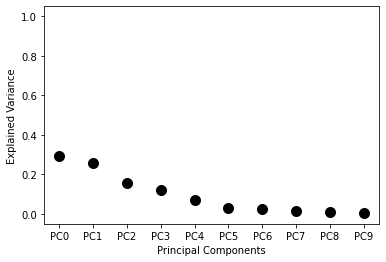

In [46]:
n_dim = 10
n_components=np.min([n_dim,dataframe_norm.shape[1]]) # if try to take more components than have channels, use amount of channels
print('The movement was originally quantified by ' + str(len(dataframe_norm.columns)) + ' kinematic variables')
pca = PCA(n_components=n_components)
pca.fit(dataframe_norm)
df_pca = pd.DataFrame(pca.transform(dataframe_norm), columns=['PC%i' % i for i in range(n_components)], index=dataframe_norm.index)
print('The dataset has now been transformed into ' + str(n_components) + ' principle components.')

# No need to edit this code cell
################################
hfig,ax = plt.subplots(1)
ax.scatter(df_pca.columns,pca.explained_variance_ratio_,color='black',s=100)
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Principal Components')
ax.set_ylim(-0.05,1.05)

fig = go.Figure()
fig.add_trace(go.Scatter(x = df_pca.columns, y = pca.explained_variance_ratio_,
                         name='right',mode='markers'))

fig.add_trace(go.Scatter(x = grf_norm['Time'], y = np.degrees(phi),
                         name='left',mode='markers'))
fig.update_layout(xaxis_title="percent gait cycle", yaxis_title='degrees',
                  width=800, height=400)

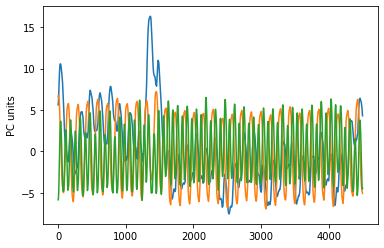

In [52]:
hfig,ax = plt.subplots(1)
# ax.set_xlabel('seconds')
ax.set_ylabel('PC units')
# ax.set_yticklabels([])

ax.plot(df_pca['PC0'])
ax.plot(df_pca['PC1'])
ax.plot(df_pca['PC2'])

In [57]:
fig = go.Figure(data=[go.Scatter3d(x=df_pca['PC0'], y=df_pca['PC1'], z=df_pca['PC2'],
                                   mode='markers',marker_size=1,line_color='black')])
fig.show()


<hr>
<br>

## NICE WORK!

<br>


<hr>

For users not in this course:
This notebook assumes that you have access to the BIOL358 shared class drive in which the dataset from [Fukuchi et al (2018)](https://peerj.com/articles/4640/) has been stored. To change the filepath, or aquire the dataset via direct download (if that is possible), edit the first code cell in Step #2 ("TASK: RUN this cell to set up the notebook (import packages, etc)" and change the datafolder path variable. And/or edit the code cells in which the data is imported. 